# Improvements from the pretraining strategy
## Statistical significance

In our paper, we showed that the pretraining strategy improves the performance of the models. However, we did not perform any statistical tests to determine whether the improvements were statistically significant. In this notebook, we will perform a t-test to determine whether they are.

In [1]:
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.stats import ttest_ind

### Testing pairs of models from raw ranks

At the core of the test is a function that loads the raw ranks produced by a pair of models being compared.
The raw ranks can be obtained by running the following code:

```sh
python -m bioblp.evaluate --model_path=<PATH_TO_MODEL>
```

The ranks are then saved to a file called `ranks.csv` in the model directory. The function below loads the ranks and returns the p-value and mean difference of the two models.

We used [Welch's test](https://en.wikipedia.org/wiki/Welch%27s_t-test), which does not assume normality nor equal variance of the two samples.

In [2]:
def compare_models(model_1, model_2):
    """Compare two models using a t-test, given their IDs"""
    reciprocals_1 = 1.0 / np.loadtxt(osp.join('..', 'models', model_1, 'ranks.csv'))
    reciprocals_2 = 1.0 / np.loadtxt(osp.join('..', 'models', model_2, 'ranks.csv'))
    t, p = ttest_ind(reciprocals_1, reciprocals_2, equal_var=False)
    mean_difference = np.mean(reciprocals_2) - np.mean(reciprocals_1)
    return p, mean_difference

At this point we assume that we have generated the raw ranks for all the models we want to compare. We can then load the raw ranks and perform the t-test.
In the next cell we populate all the data, by adding the IDs of the base model, followed by the IDs of the pre-trained model.

In [3]:
TRANSE = 'TransE'
COMPLEX = 'ComplEx'
ROTATE = 'RotatE'
BIOBLP_P = 'BioBLP-P'
BIOBLP_M = 'BioBLP-M'
BIOBLP_D = 'BioBLP-D'


data = [[TRANSE, BIOBLP_P, '36viovqn', '38uz9fjs'],
        [TRANSE, BIOBLP_M, '36viovqn', '38uz9fjs'],
        [TRANSE, BIOBLP_D, '36viovqn', '38uz9fjs'],
        [COMPLEX, BIOBLP_P, '36viovqn', '38uz9fjs'],
        [COMPLEX, BIOBLP_M, '36viovqn', '38uz9fjs'],
        [COMPLEX, BIOBLP_D, '36viovqn', '38uz9fjs'],
        [ROTATE, BIOBLP_P, '36viovqn', '38uz9fjs'],
        [ROTATE, BIOBLP_M, '36viovqn', '38uz9fjs'],
        [ROTATE, BIOBLP_D, '36viovqn', '38uz9fjs']]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['scoring-function', 'encoder', 'base-id', 'pretrained-id'])
df['scoring-function'] = df['scoring-function'].astype(CategoricalDtype(categories=[TRANSE, COMPLEX, ROTATE], ordered=True))
df['encoder'] = df['encoder'].astype(CategoricalDtype(categories=[BIOBLP_P, BIOBLP_M, BIOBLP_D], ordered=True))
df

,scoring-function,encoder,base-id,pretrained-id
0,TransE,BioBLP-P,36viovqn,38uz9fjs
1,TransE,BioBLP-M,36viovqn,38uz9fjs
2,TransE,BioBLP-D,36viovqn,38uz9fjs
3,ComplEx,BioBLP-P,36viovqn,38uz9fjs
4,ComplEx,BioBLP-M,36viovqn,38uz9fjs
5,ComplEx,BioBLP-D,36viovqn,38uz9fjs
6,RotatE,BioBLP-P,36viovqn,38uz9fjs
7,RotatE,BioBLP-M,36viovqn,38uz9fjs
8,RotatE,BioBLP-D,36viovqn,38uz9fjs


Now we can run the t-test, adding the p-value and mean difference to the DataFrame.

In [4]:
df['p-value'], df['mean-difference'] = zip(*df.apply(lambda row: compare_models(row['base-id'], row['pretrained-id']), axis=1))
df

,scoring-function,encoder,base-id,pretrained-id,p-value,mean-difference
0,TransE,BioBLP-P,36viovqn,38uz9fjs,0.384252,-0.037661
1,TransE,BioBLP-M,36viovqn,38uz9fjs,0.384252,-0.037661
2,TransE,BioBLP-D,36viovqn,38uz9fjs,0.384252,-0.037661
3,ComplEx,BioBLP-P,36viovqn,38uz9fjs,0.384252,-0.037661
4,ComplEx,BioBLP-M,36viovqn,38uz9fjs,0.384252,-0.037661
5,ComplEx,BioBLP-D,36viovqn,38uz9fjs,0.384252,-0.037661
6,RotatE,BioBLP-P,36viovqn,38uz9fjs,0.384252,-0.037661
7,RotatE,BioBLP-M,36viovqn,38uz9fjs,0.384252,-0.037661
8,RotatE,BioBLP-D,36viovqn,38uz9fjs,0.384252,-0.037661


Lastly, we plot the results grouping by scoring function and encoder, and adding an asterisk if the p-value is less than 0.05.

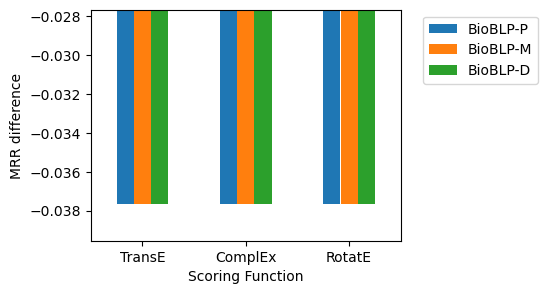

In [5]:
# Group by scoring function, then by encoder, and plot the mean difference
fig, ax = plt.subplots(figsize=(4, 3))
df.groupby(['scoring-function', 'encoder']).mean(numeric_only=True)['mean-difference'].unstack().plot.bar(ax=ax, rot=0)
# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

# Iterate over the bars and add an asterisk if the p-value is less than 0.05
for i, p in enumerate(ax.patches):
    p_value = df.iloc[i]['p-value']
    if p_value < 0.05:
        ax.annotate('*', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                    textcoords='offset points')

# Set the ylim to be a bit larger than the max value
ax.set_ylim(top=df['mean-difference'].max() + 0.01)
ax.set_xlabel('Scoring Function')
ax.set_ylabel('MRR difference');

In [6]:
fig.savefig('pretraining-significance.pdf', bbox_inches='tight')